In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [ ]:
import pandas as pd
import numpy as np

# Load datasets
df1 = pd.read_csv('salary/eda_data.csv')               # final target dataset
df2 = pd.read_csv('salary/glassdoor_jobs.csv')         # raw dataset
df3 = pd.read_csv('salary/salary_data_cleaned.csv')    # intermediate dataset

# Merge all rows together — aligning columns automatically
df = pd.concat([df1, df2, df3], axis=0, ignore_index=True)

# Replace any missing values in new columns (that were not in df2/df3) with NaN
df = df.replace(r'^\s*$', np.nan, regex=True)

# Check merged shape and columns
print("✅ Final dataset shape:", df.shape)
print("\n✅ Final dataset columns:\n", df.columns.tolist())

# Preview
df.head()


✅ Final dataset shape: (2440, 33)

✅ Final dataset columns:
 ['Unnamed: 0', 'Job Title', 'Salary Estimate', 'Job Description', 'Rating', 'Company Name', 'Location', 'Headquarters', 'Size', 'Founded', 'Type of ownership', 'Industry', 'Sector', 'Revenue', 'Competitors', 'hourly', 'employer_provided', 'min_salary', 'max_salary', 'avg_salary', 'company_txt', 'job_state', 'same_state', 'age', 'python_yn', 'R_yn', 'spark', 'aws', 'excel', 'job_simp', 'seniority', 'desc_len', 'num_comp']


,Unnamed: 0,Job Title,Salary Estimate,Job Description,Rating,Company Name,Location,Headquarters,Size,Founded,...,age,python_yn,R_yn,spark,aws,excel,job_simp,seniority,desc_len,num_comp
0,0.0,Data Scientist,$53K-$91K (Glassdoor est.),"Data Scientist\nLocation: Albuquerque, NM\nEdu...",3.8,Tecolote Research\n3.8,"Albuquerque, NM","Goleta, CA",501 to 1000 employees,1973,...,47.0,1.0,0.0,0.0,0.0,1.0,data scientist,na,2536.0,0.0
1,1.0,Healthcare Data Scientist,$63K-$112K (Glassdoor est.),What You Will Do:\n\nI. General Summary\n\nThe...,3.4,University of Maryland Medical System\n3.4,"Linthicum, MD","Baltimore, MD",10000+ employees,1984,...,36.0,1.0,0.0,0.0,0.0,0.0,data scientist,na,4783.0,0.0
2,2.0,Data Scientist,$80K-$90K (Glassdoor est.),"KnowBe4, Inc. is a high growth information sec...",4.8,KnowBe4\n4.8,"Clearwater, FL","Clearwater, FL",501 to 1000 employees,2010,...,10.0,1.0,0.0,1.0,0.0,1.0,data scientist,na,3461.0,0.0
3,3.0,Data Scientist,$56K-$97K (Glassdoor est.),*Organization and Job ID**\nJob ID: 310709\n\n...,3.8,PNNL\n3.8,"Richland, WA","Richland, WA",1001 to 5000 employees,1965,...,55.0,1.0,0.0,0.0,0.0,0.0,data scientist,na,3883.0,3.0
4,4.0,Data Scientist,$86K-$143K (Glassdoor est.),Data Scientist\nAffinity Solutions / Marketing...,2.9,Affinity Solutions\n2.9,"New York, NY","New York, NY",51 to 200 employees,1998,...,22.0,1.0,0.0,0.0,0.0,1.0,data scientist,na,2728.0,3.0


# Our target value is average salary

In [80]:
# Drop rows where avg_salary is missing
df = df.dropna(subset=['avg_salary']).reset_index(drop=True)

print(f"✅ Cleaned dataset shape: {df.shape}")
print(f"✅ Remaining missing values: {df.isnull().sum().sum()}")


✅ Cleaned dataset shape: (1484, 33)
✅ Remaining missing values: 3710


In [81]:
# --- Clean, Impute & Prepare Salary Dataset (Full DF First, Then Split) ---

import numpy as np
import pandas as pd
import re
from sklearn.model_selection import train_test_split

# Step 1: Define categorical (text) and numeric columns
text_cols = [
    'Job Title', 'Salary Estimate', 'Job Description', 'Company Name',
    'Location', 'Headquarters', 'Size', 'Type of ownership', 'Industry',
    'Sector', 'Revenue', 'Competitors', 'company_txt', 'job_state',
    'job_simp', 'seniority'
]

num_cols = [
    'Unnamed: 0', 'Rating', 'Founded', 'hourly', 'employer_provided',
    'min_salary', 'max_salary', 'same_state', 'age', 'python_yn',
    'R_yn', 'spark', 'aws', 'excel', 'desc_len', 'num_comp'
]

# Step 2: Function to clean text columns (remove numeric-like junk)
def clean_text_columns(df, columns):
    for col in columns:
        if col in df.columns and df[col].dtype == 'object':
            # Replace isolated numeric-like entries with NaN
            df[col] = df[col].replace(
                r'^[-+]?[0-9]*\.?[0-9]+([eE][-+]?[0-9]+)?$', np.nan, regex=True
            )
            # Strip whitespace
            df[col] = df[col].astype(str).str.strip()
    return df

# Step 3: Apply text cleaning to df
df = clean_text_columns(df, text_cols)

# Step 4: Impute missing categorical values
for col in text_cols:
    if col in df.columns:
        df[col] = df[col].fillna('Unknown')

# Step 5: Impute missing numeric values with median and clip negatives
for col in num_cols:
    if col in df.columns:
        median_val = df[col].median()
        df[col] = df[col].fillna(median_val).clip(lower=0)

# Step 6: Ensure correct dtypes
df[num_cols] = df[num_cols].apply(pd.to_numeric, errors='coerce')
df[text_cols] = df[text_cols].astype(str)

# Step 7: Drop duplicates or corrupted rows (optional, safety)
df = df.drop_duplicates().reset_index(drop=True)

# Step 8: Split data AFTER cleaning
X = df.drop(columns='avg_salary')
y = df['avg_salary']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# Step 9: Final verification
print("\n--- Missing Values After Cleaning ---")
print(df.isnull().sum().sum())

print("\n--- Data Type Summary ---")
print(df.dtypes.value_counts())

print("\n✅ Data cleaned, consistent, and split safely (no row mismatch).")
print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

print("Total missing values after final cleaning:", df.isnull().sum().sum())




--- Missing Values After Cleaning ---
0

--- Data Type Summary ---
float64    16
object     16
int64       1
Name: count, dtype: int64

✅ Data cleaned, consistent, and split safely (no row mismatch).
Train shape: (846, 32), Test shape: (363, 32)
Total missing values after final cleaning: 0


In [82]:
# --- Step 1: Define column types based on your dataset ---
text_cols = X_train.select_dtypes(include=['object']).columns.tolist()
num_cols = X_train.select_dtypes(include=['float64', 'int64']).columns.tolist()

# --- Step 2: Clean text-like columns (remove numeric-like entries or NaNs) ---
def clean_text_columns(df, columns):
    for col in columns:
        if col in df.columns:
            # Replace purely numeric or scientific notation values with NaN
            df[col] = df[col].replace(r'^[-+]?[0-9]*\.?[0-9]+([eE][-+]?[0-9]+)?$', np.nan, regex=True)
            # Strip leading/trailing spaces
            df[col] = df[col].astype(str).str.strip()
            # Replace empty strings with NaN
            df[col] = df[col].replace('', np.nan)
    return df

X_train = clean_text_columns(X_train, text_cols)
X_test = clean_text_columns(X_test, text_cols)

# --- Step 3: Impute missing categorical values with 'Unknown' ---
for col in text_cols:
    if col in X_train.columns:
        X_train[col] = X_train[col].fillna('Unknown')
    if col in X_test.columns:
        X_test[col] = X_test[col].fillna('Unknown')

# --- Step 4: Impute missing numeric values with median and clip negatives ---
for col in num_cols:
    if col in X_train.columns:
        median_val = X_train[col].median()
        X_train[col] = X_train[col].fillna(median_val).clip(lower=0)
    if col in X_test.columns:
        median_val = X_test[col].median()
        X_test[col] = X_test[col].fillna(median_val).clip(lower=0)

# --- Step 5: Drop irrelevant columns if present (index-like columns) ---
drop_cols = ['Unnamed: 0']
X_train.drop(columns=drop_cols, errors='ignore', inplace=True)
X_test.drop(columns=drop_cols, errors='ignore', inplace=True)

# --- Step 6: Confirm cleaning status ---
print("\n✅ --- Missing Values After Cleaning (Train) ---")
print(X_train.isnull().sum()[X_train.isnull().sum() > 0])

print("\n✅ --- Missing Values After Cleaning (Test) ---")
print(X_test.isnull().sum()[X_test.isnull().sum() > 0])

print("\n✅ Data cleaning complete.")
print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")



✅ --- Missing Values After Cleaning (Train) ---
Series([], dtype: int64)

✅ --- Missing Values After Cleaning (Test) ---
Series([], dtype: int64)

✅ Data cleaning complete.
Train shape: (846, 31), Test shape: (363, 31)


In [83]:
# --- Remove Duplicates and Cap Outliers for Salary Dataset ---

# Step 1: Remove duplicates
initial_train_rows = X_train.shape[0]
initial_test_rows = X_test.shape[0]

X_train.drop_duplicates(inplace=True)
X_test.drop_duplicates(inplace=True)

print(f"✅ Removed {initial_train_rows - X_train.shape[0]} duplicate rows from TRAIN data.")
print(f"✅ Removed {initial_test_rows - X_test.shape[0]} duplicate rows from TEST data.")

# Step 2: Define outlier capping function using IQR
def cap_outliers(df, col):
    """Caps outliers in a numeric column using IQR method."""
    if df[col].dtype in [np.float64, np.int64]:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        df[col] = np.clip(df[col], lower, upper)

# Step 3: Define numeric columns for outlier capping
outlier_cols = [
    'Rating', 'Founded', 'min_salary', 'max_salary', 'age',
    'desc_len', 'num_comp'
]

# Step 4: Apply outlier capping
for col in outlier_cols:
    if col in X_train.columns:
        cap_outliers(X_train, col)
    if col in X_test.columns:
        cap_outliers(X_test, col)

# Step 5: Confirm capping results
print("\n✅ Outliers capped using IQR for the following columns:\n")
for col in outlier_cols:
    if col in X_train.columns:
        print(f"Train '{col}': min={X_train[col].min():.2f}, max={X_train[col].max():.2f}")
    if col in X_test.columns:
        print(f"Test  '{col}': min={X_test[col].min():.2f}, max={X_test[col].max():.2f}")

print("\n🎯 Duplicate removal and outlier capping completed successfully!")

✅ Removed 144 duplicate rows from TRAIN data.
✅ Removed 31 duplicate rows from TEST data.

✅ Outliers capped using IQR for the following columns:

Train 'Rating': min=2.31, max=5.00
Test  'Rating': min=2.10, max=5.00
Train 'Founded': min=1853.25, max=2019.00
Test  'Founded': min=1813.88, max=2019.00
Train 'min_salary': min=10.00, max=145.50
Test  'min_salary': min=15.00, max=147.50
Train 'max_salary': min=17.50, max=229.50
Test  'max_salary': min=17.38, max=234.38
Train 'age': min=0.00, max=120.38
Test  'age': min=0.00, max=140.00
Train 'desc_len': min=3492.50, max=3976.50
Test  'desc_len': min=2695.25, max=4729.25
Train 'num_comp': min=0.00, max=0.00
Test  'num_comp': min=0.00, max=0.00

🎯 Duplicate removal and outlier capping completed successfully!


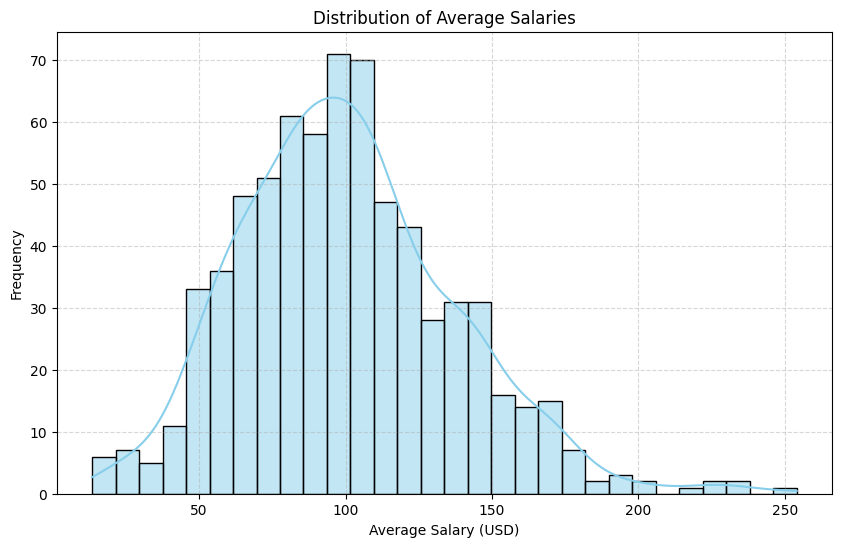

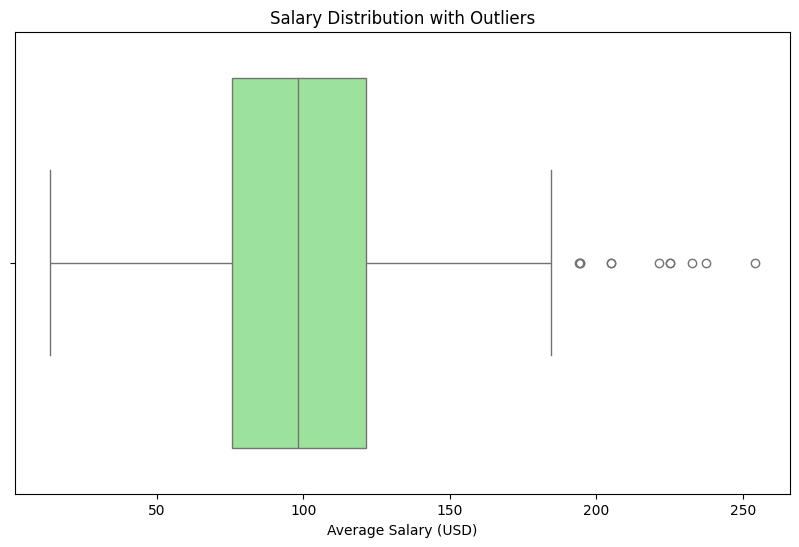

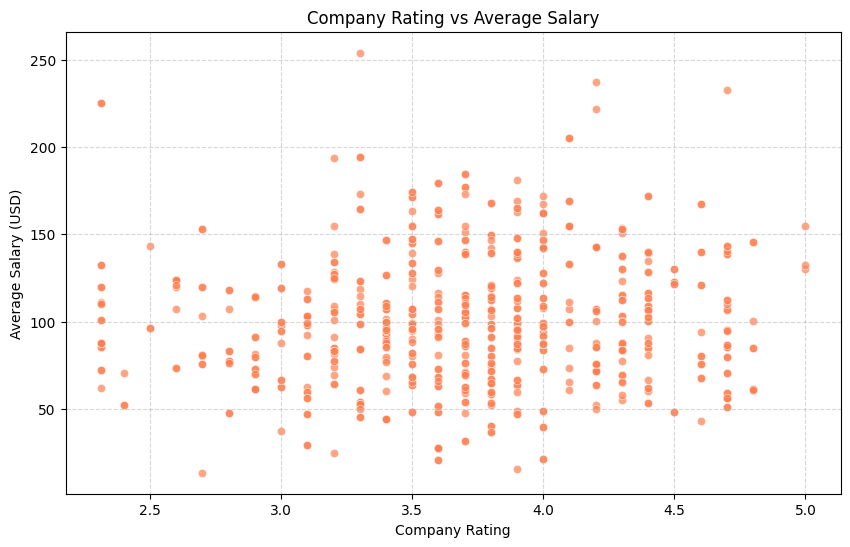

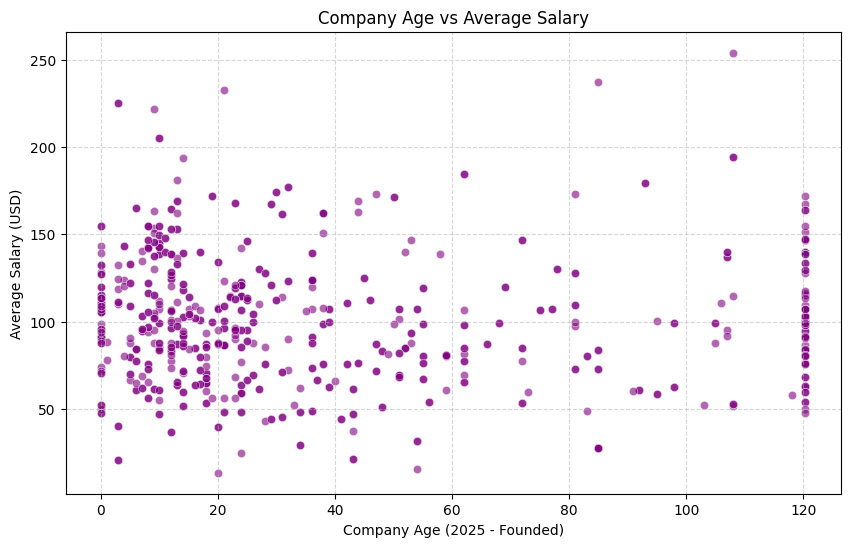

/tmp/ipython-input-2462420335.py:66: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




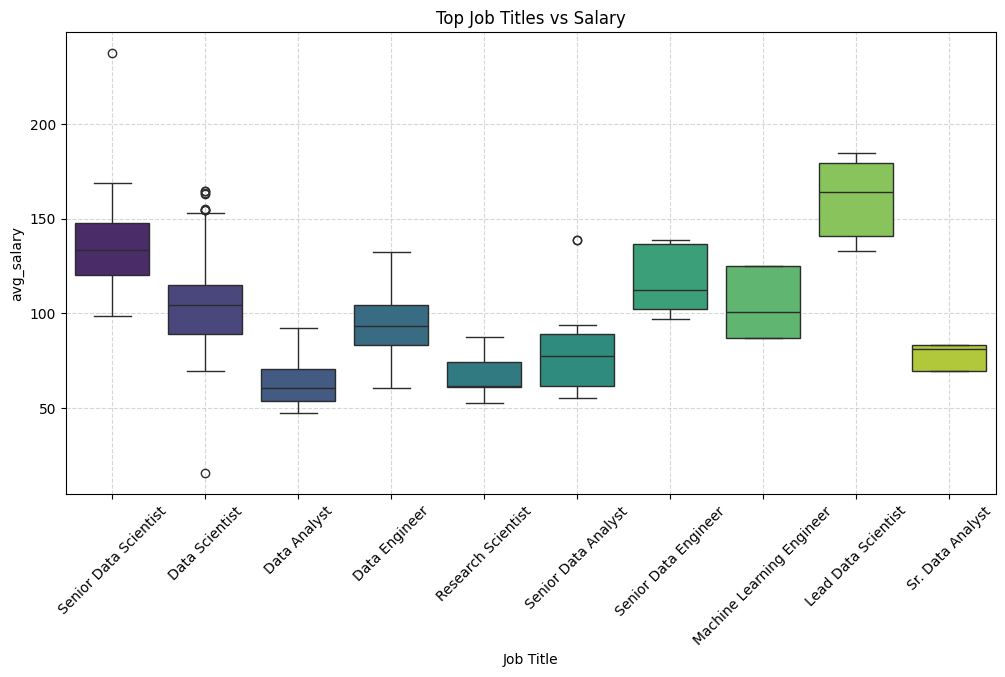

/tmp/ipython-input-2462420335.py:73: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




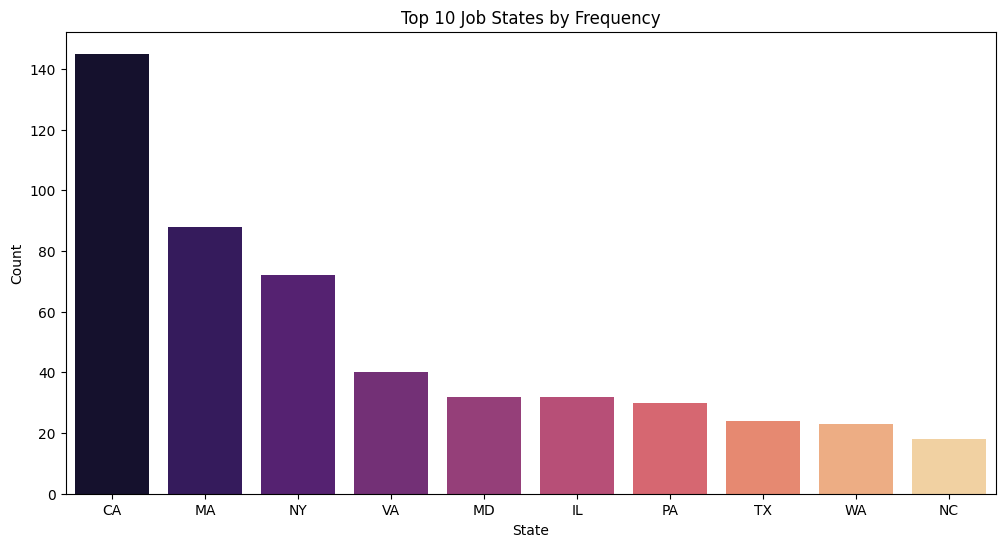

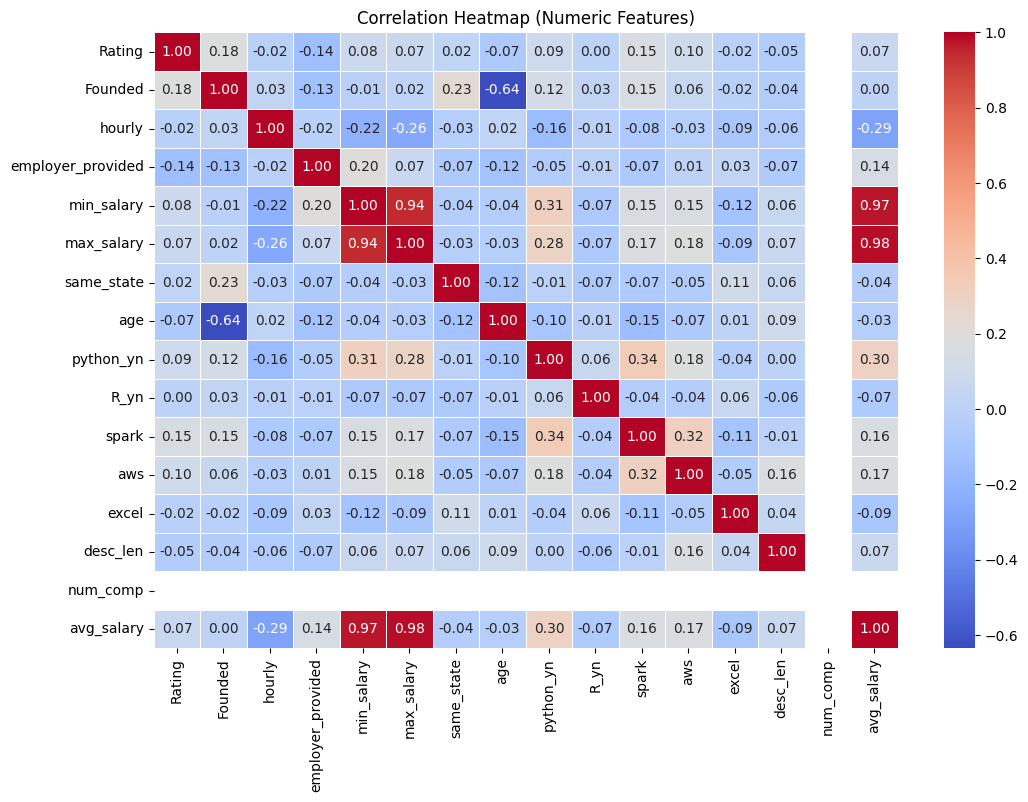

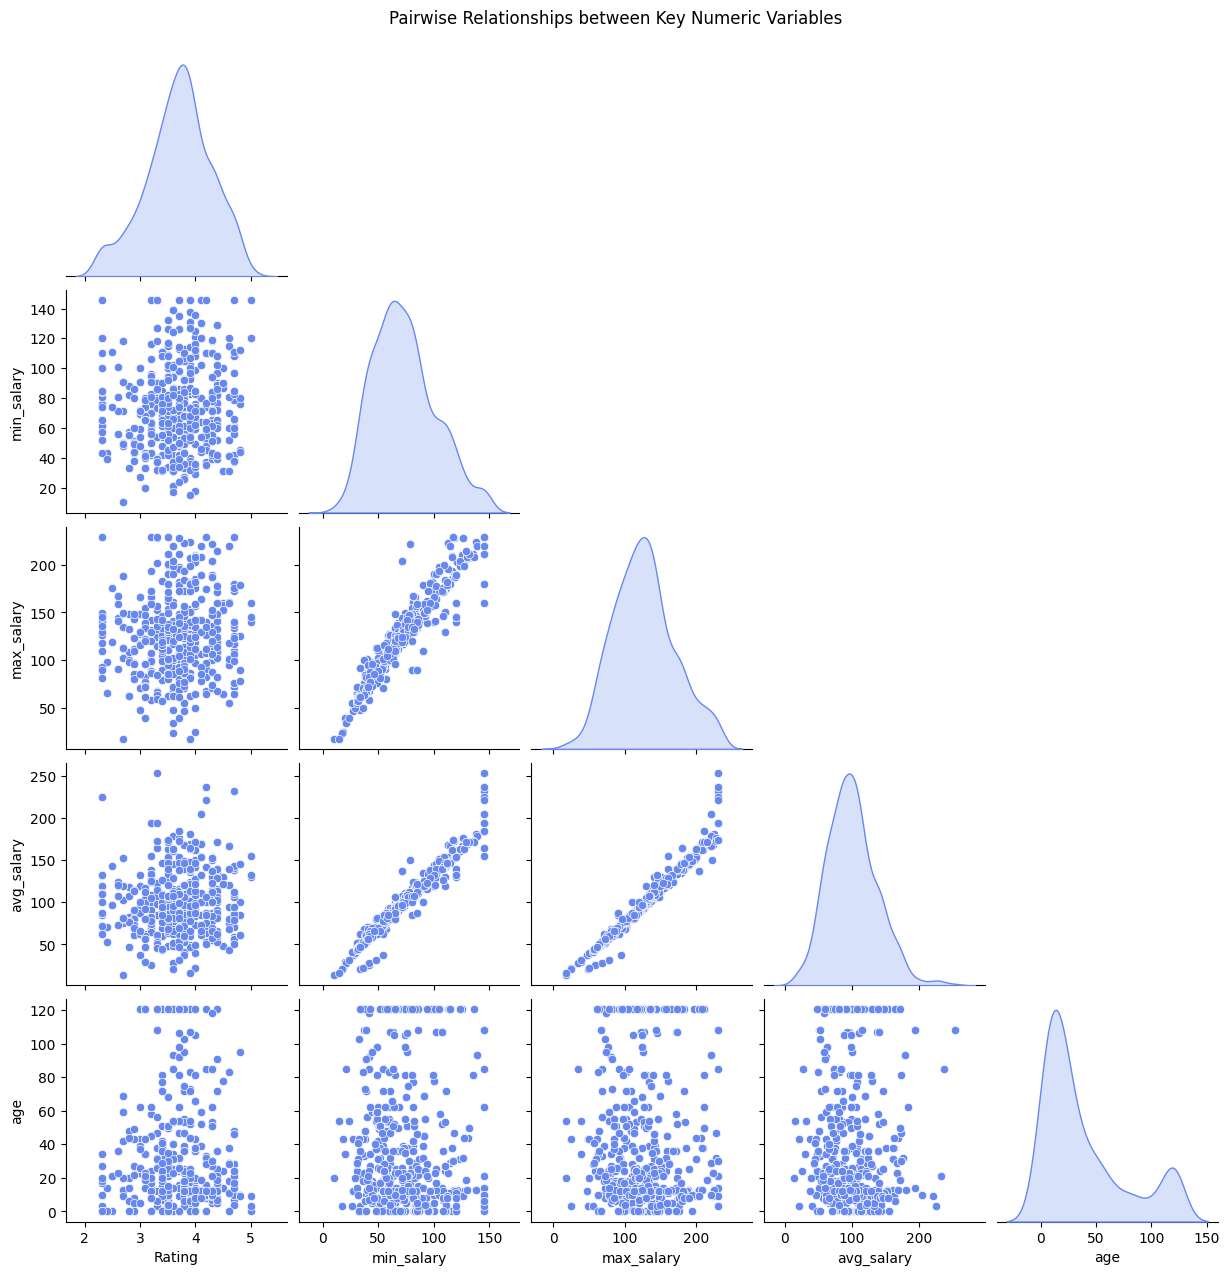

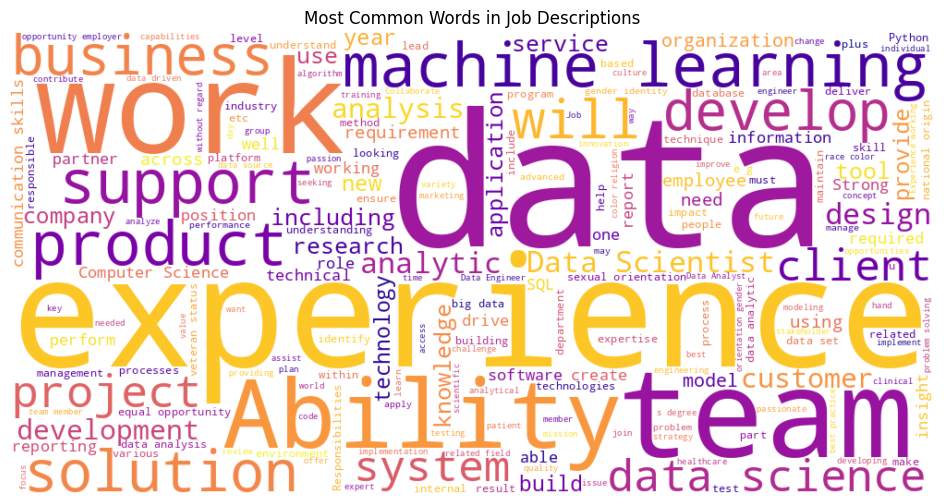

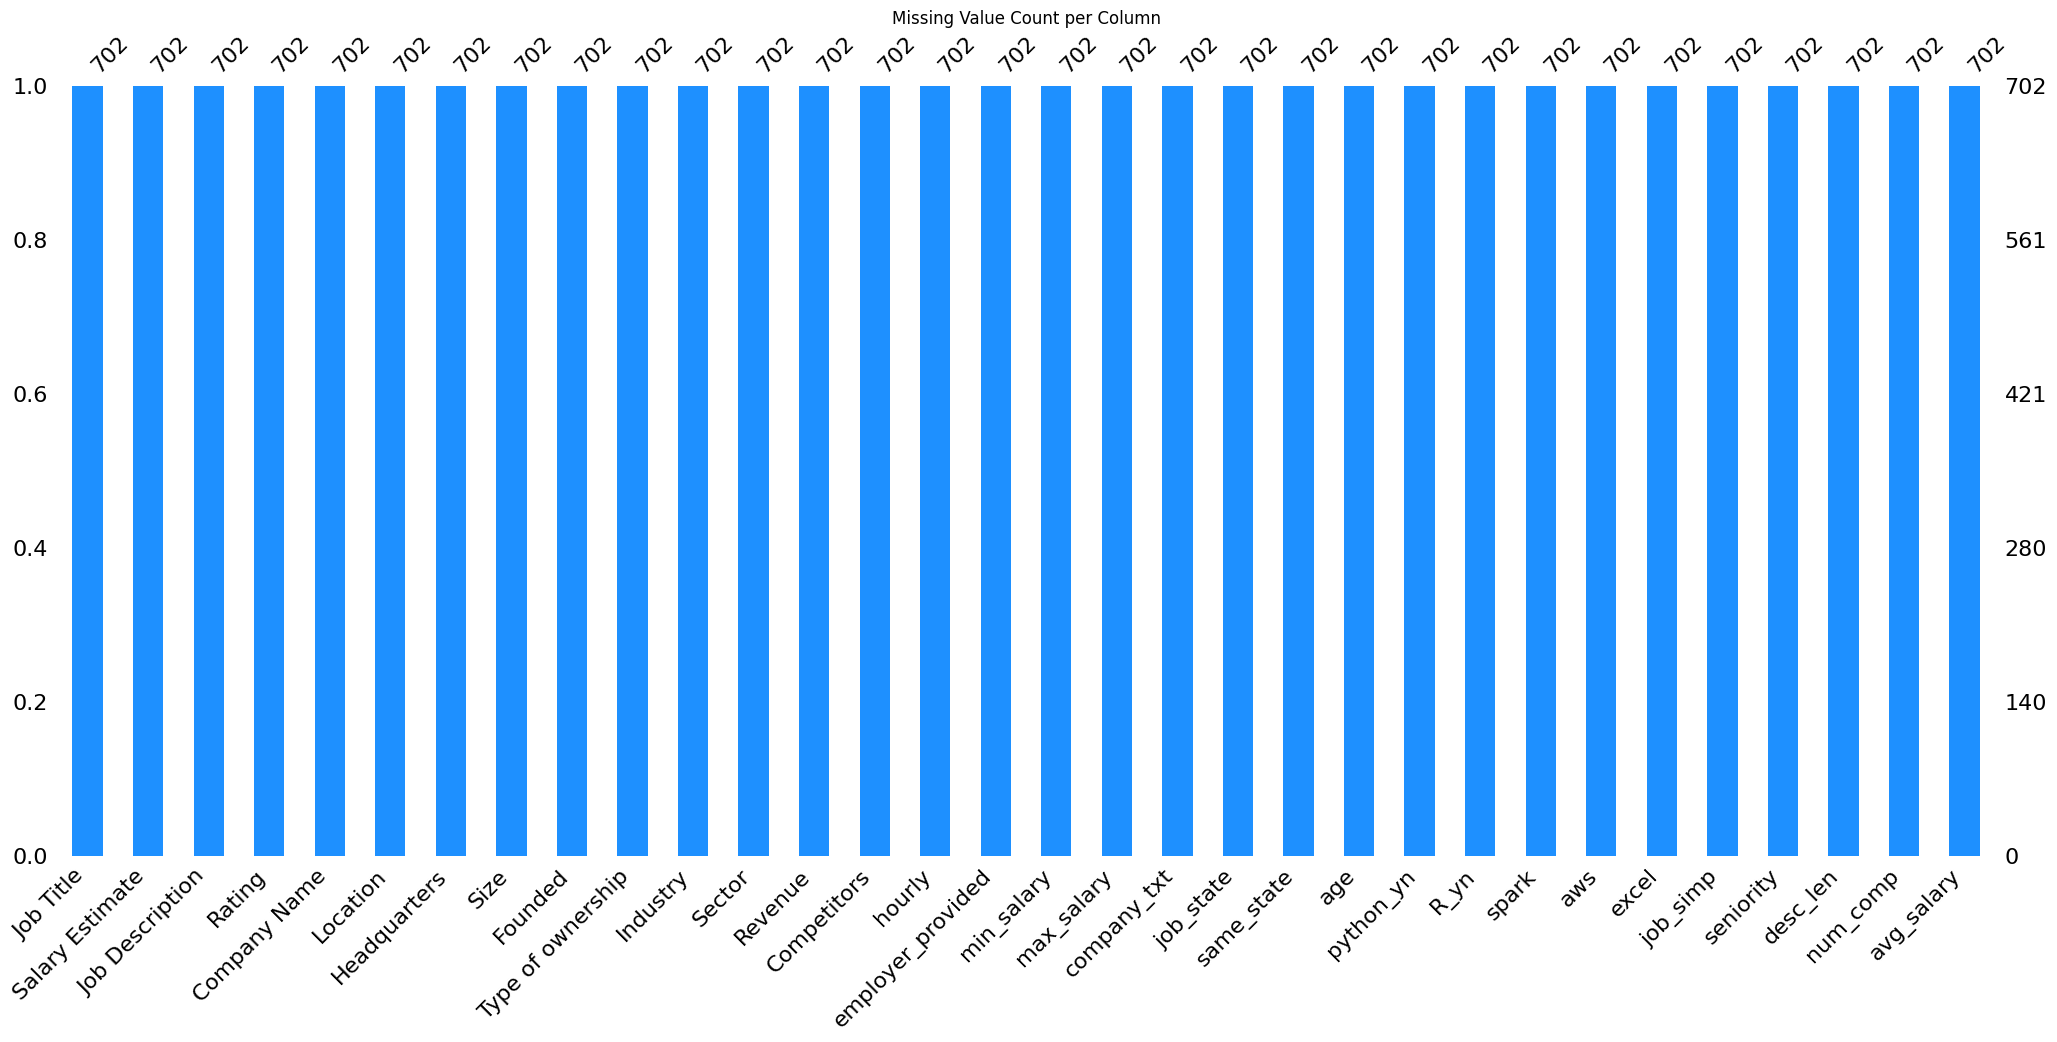

/usr/local/lib/python3.12/dist-packages/seaborn/matrix.py:309: UserWarning:

Attempting to set identical low and high xlims makes transformation singular; automatically expanding.

/usr/local/lib/python3.12/dist-packages/seaborn/matrix.py:309: UserWarning:

Attempting to set identical low and high ylims makes transformation singular; automatically expanding.



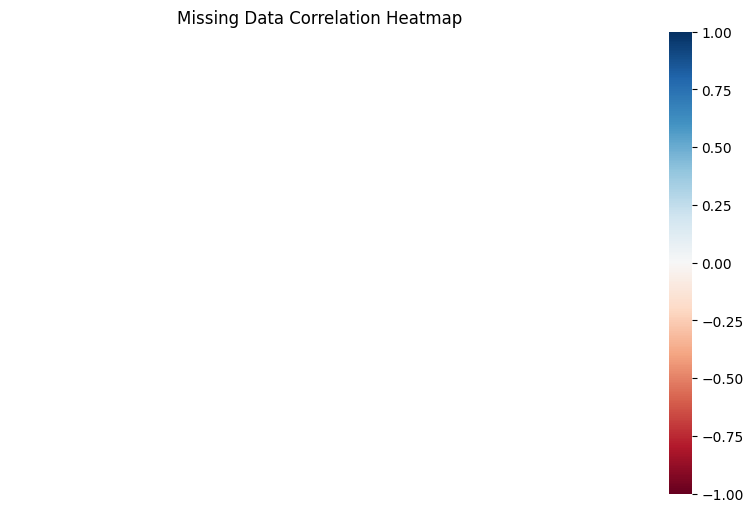

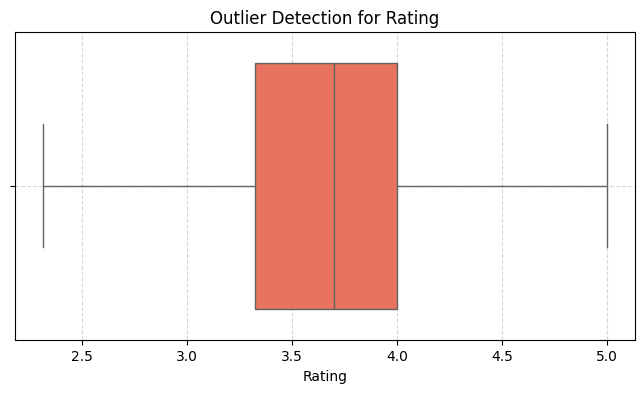

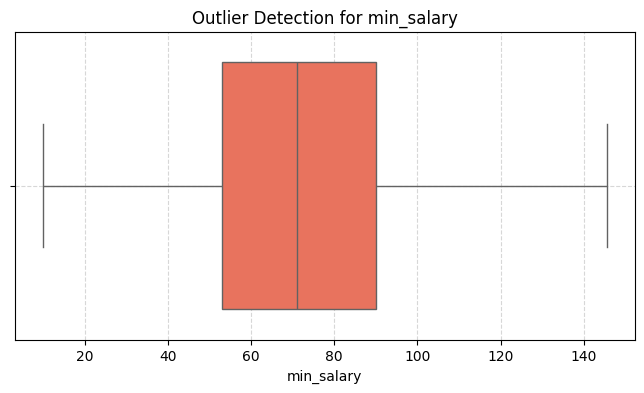

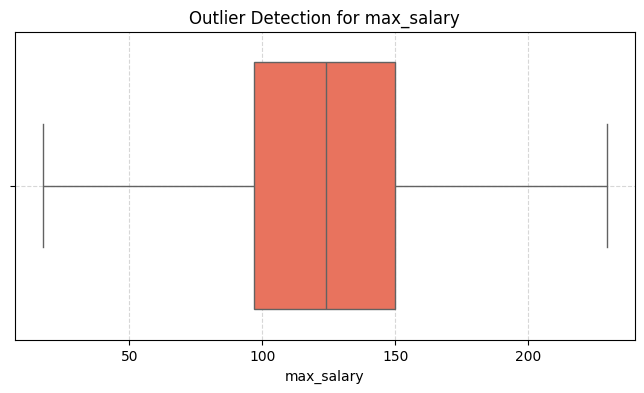

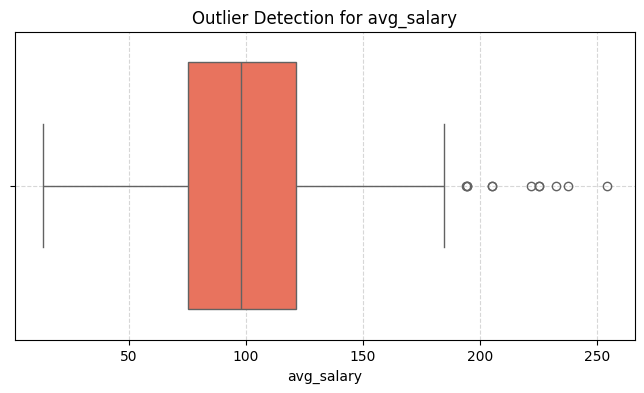

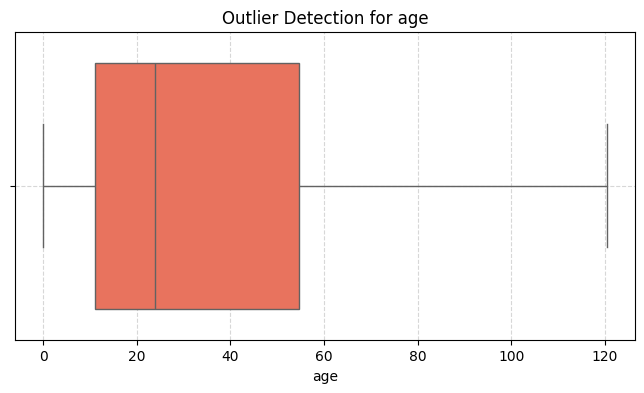

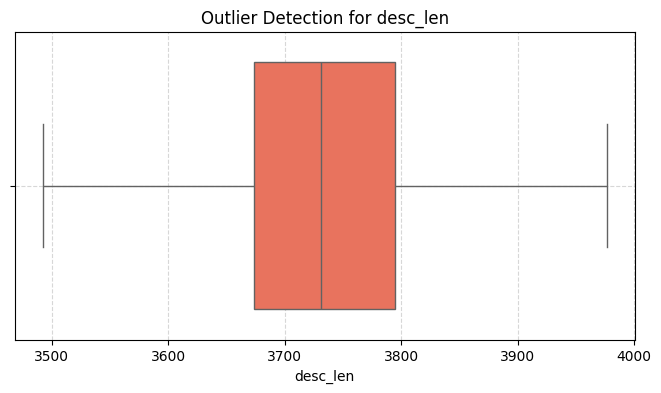

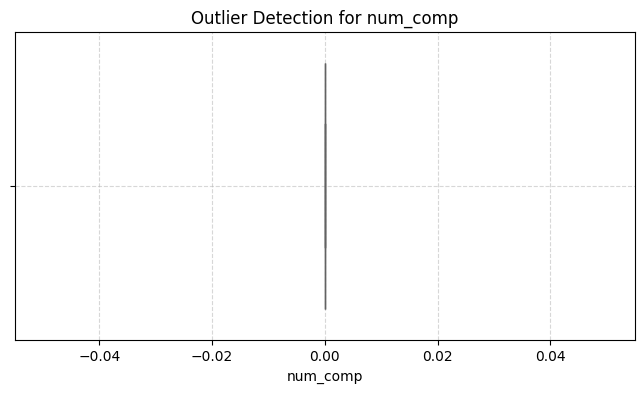

/tmp/ipython-input-2462420335.py:150: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




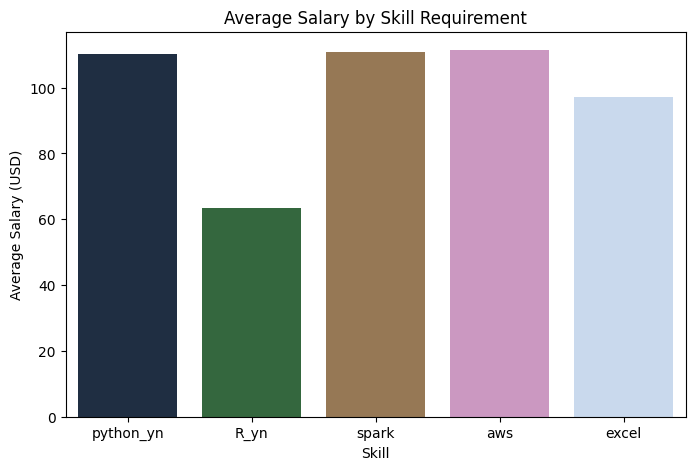

In [84]:
# ==========================================
# 🔹 SALARY DATA EXPLORATION & VISUALIZATION
# ==========================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from wordcloud import WordCloud
import missingno as msno
from scipy import stats

# Align y_train with X_train after cleaning
y_train = y_train.loc[X_train.index].reset_index(drop=True)
X_train = X_train.reset_index(drop=True)

# Use your processed training data
df_vis = X_train.copy()
df_vis['avg_salary'] = y_train.values

plt.style.use('seaborn-v0_8-muted')
sns.set_palette('coolwarm')

# -------------------------------
# 1️⃣ BASIC DISTRIBUTION PLOTS
# -------------------------------
plt.figure(figsize=(10, 6))
sns.histplot(df_vis['avg_salary'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of Average Salaries')
plt.xlabel('Average Salary (USD)')
plt.ylabel('Frequency')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x=df_vis['avg_salary'], color='lightgreen')
plt.title('Salary Distribution with Outliers')
plt.xlabel('Average Salary (USD)')
plt.show()

# -------------------------------
# 2️⃣ FEATURE RELATIONSHIPS
# -------------------------------
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Rating', y='avg_salary', data=df_vis, color='coral', alpha=0.7)
plt.title('Company Rating vs Average Salary')
plt.xlabel('Company Rating')
plt.ylabel('Average Salary (USD)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(x='age', y='avg_salary', data=df_vis, color='purple', alpha=0.6)
plt.title('Company Age vs Average Salary')
plt.xlabel('Company Age (2025 - Founded)')
plt.ylabel('Average Salary (USD)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# -------------------------------
# 3️⃣ CATEGORICAL FEATURE INSIGHTS
# -------------------------------
top_jobs = df_vis['Job Title'].value_counts().head(10).index
plt.figure(figsize=(12, 6))
sns.boxplot(x='Job Title', y='avg_salary', data=df_vis[df_vis['Job Title'].isin(top_jobs)], palette='viridis')
plt.title('Top Job Titles vs Salary')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(x=df_vis['job_state'].value_counts().index[:10],
            y=df_vis['job_state'].value_counts().values[:10],
            palette='magma')
plt.title('Top 10 Job States by Frequency')
plt.xlabel('State')
plt.ylabel('Count')
plt.show()

# -------------------------------
# 4️⃣ CORRELATION & HEATMAP
# -------------------------------
plt.figure(figsize=(12, 8))
corr = df_vis.select_dtypes(include=['float64', 'int64']).corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap (Numeric Features)')
plt.show()

# -------------------------------
# 5️⃣ PAIRPLOT (NUMERIC RELATIONSHIPS)
# -------------------------------
sns.pairplot(df_vis[['Rating', 'min_salary', 'max_salary', 'avg_salary', 'age']], diag_kind='kde', corner=True)
plt.suptitle('Pairwise Relationships between Key Numeric Variables', y=1.02)
plt.show()

# -------------------------------
# 6️⃣ WORD CLOUDS (TEXT FEATURES)
# -------------------------------
plt.figure(figsize=(12, 6))
text = " ".join(df_vis['Job Description'].astype(str))
wc = WordCloud(width=1000, height=500, background_color='white', colormap='plasma').generate(text)
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Words in Job Descriptions')
plt.show()

# -------------------------------
# 7️⃣ MISSING VALUE VISUALIZATION
# -------------------------------
msno.bar(df_vis, color='dodgerblue')
plt.title("Missing Value Count per Column")
plt.show()

msno.heatmap(df_vis, figsize=(10, 6))
plt.title("Missing Data Correlation Heatmap")
plt.show()

# -------------------------------
# 8️⃣ OUTLIER DETECTION (Boxplots)
# -------------------------------
num_features = ['Rating', 'min_salary', 'max_salary', 'avg_salary', 'age', 'desc_len', 'num_comp']
for col in num_features:
    if col in df_vis.columns:
        plt.figure(figsize=(8, 4))
        sns.boxplot(x=df_vis[col], color='tomato')
        plt.title(f'Outlier Detection for {col}')
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.show()

# -------------------------------
# 9️⃣ ADVANCED PLOTLY INTERACTIVE VISUALS
# -------------------------------
fig = px.scatter(df_vis, x='Rating', y='avg_salary', color='job_state',
                 title='Interactive: Company Rating vs Salary by State',
                 hover_data=['Company Name', 'Job Title'])
fig.show()

fig = px.box(df_vis, x='job_state', y='avg_salary', points='all',
             title='Interactive: Salary Distribution by Job State')
fig.show()

# -------------------------------
# 🔟 SALARY BY TECHNOLOGY
# -------------------------------
skills = ['python_yn', 'R_yn', 'spark', 'aws', 'excel']
skill_salary = {skill: df_vis[df_vis[skill] == 1]['avg_salary'].mean() for skill in skills if skill in df_vis.columns}

plt.figure(figsize=(8, 5))
sns.barplot(x=list(skill_salary.keys()), y=list(skill_salary.values()), palette='cubehelix')
plt.title('Average Salary by Skill Requirement')
plt.xlabel('Skill')
plt.ylabel('Average Salary (USD)')
plt.show()


In [85]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import pandas as pd

# 1. Separate features and target
# Assuming df is your merged and cleaned dataset
X = df.drop(columns=['avg_salary'], errors='ignore')
y = df['avg_salary']

# 2. Define numeric and categorical features
num_features = [
    'Rating', 'Founded', 'min_salary', 'max_salary', 'age',
    'desc_len', 'num_comp', 'hourly', 'employer_provided',
    'same_state', 'python_yn', 'R_yn', 'spark', 'aws', 'excel'
]

cat_features = [
    'Job Title', 'Company Name', 'Location', 'Headquarters', 'Size',
    'Type of ownership', 'Industry', 'Sector', 'Revenue',
    'job_state', 'job_simp', 'seniority'
]


# 3. Create preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_features)
    ],
    remainder='drop'  # drop any extra columns not listed above
)


# 4. Wrap in a pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

# 5. Fit & transform
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# Fit the preprocessor on training data, transform both sets
X_train_processed = pipeline.fit_transform(X_train)
X_test_processed = pipeline.transform(X_test)


# Extract all transformed feature names (numeric + one-hot)
feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()

# Convert to DataFrame
X_train_df = pd.DataFrame(X_train_processed, columns=feature_names)
X_test_df = pd.DataFrame(X_test_processed, columns=feature_names)

print("✅ Preprocessing complete!")
print(f"X_train shape: {X_train_df.shape}")
print(f"X_test shape: {X_test_df.shape}")

print("\nSample of processed features:")
print(X_train_df.head(3))


✅ Preprocessing complete!
X_train shape: (846, 1143)
X_test shape: (363, 1143)

Sample of processed features:
   num__Rating  num__Founded  num__min_salary  num__max_salary  num__age  \
0    -0.069102      0.336675        -1.411770        -1.250942 -0.585099   
1    -1.059949      0.354640        -0.986627        -0.711235 -0.759564   
2    -0.493750      0.149046         4.180496         4.011196  1.237084   

   num__desc_len  num__num_comp  num__hourly  num__employer_provided  \
0      -0.065597      -0.540185    -0.167172               -0.129719   
1       0.796109      -0.540185    -0.167172               -0.129719   
2       0.587746       1.970786    -0.167172               -0.129719   

   num__same_state  ...  cat__job_simp_data scientist  cat__job_simp_director  \
0         0.909513  ...                           0.0                     0.0   
1        -1.099490  ...                           0.0                     0.0   
2        -1.099490  ...                           0.0

In [86]:
!pip install catboost --quiet

In [87]:
print("NaNs in X_train_df:", X_train_df.isnull().sum().sum())
print("NaNs in X_test_df:", X_test_df.isnull().sum().sum())
print("NaNs in y_train:", y_train.isnull().sum())
print("NaNs in y_test:", y_test.isnull().sum())


NaNs in X_train_df: 0
NaNs in X_test_df: 0
NaNs in y_train: 0
NaNs in y_test: 0


🔍 Model Evaluation Results:
--------------------------------------------------------------------------------
Linear Regression      | MAE:    3.791 | RMSE:    9.881 | R²:  0.9369
Ridge Regression       | MAE:    1.047 | RMSE:    2.185 | R²:  0.9969
Lasso Regression       | MAE:    0.874 | RMSE:    2.192 | R²:  0.9969
ElasticNet             | MAE:    0.961 | RMSE:    2.174 | R²:  0.9969
Decision Tree          | MAE:    0.523 | RMSE:    1.706 | R²:  0.9981
Random Forest          | MAE:    0.583 | RMSE:    1.259 | R²:  0.9990
Extra Trees            | MAE:    0.240 | RMSE:    0.959 | R²:  0.9994
Gradient Boosting      | MAE:    0.570 | RMSE:    0.806 | R²:  0.9996
HistGradientBoosting   | MAE:    1.025 | RMSE:    3.301 | R²:  0.9930
AdaBoost               | MAE:    4.116 | RMSE:    4.998 | R²:  0.9839
KNN Regressor          | MAE:   11.846 | RMSE:   16.382 | R²:  0.8267
SVR (RBF)              | MAE:    4.152 | RMSE:   12.480 | R²:  0.8994
❌ XGBoost                failed: feature_names must

<Figure size 1200x600 with 0 Axes>

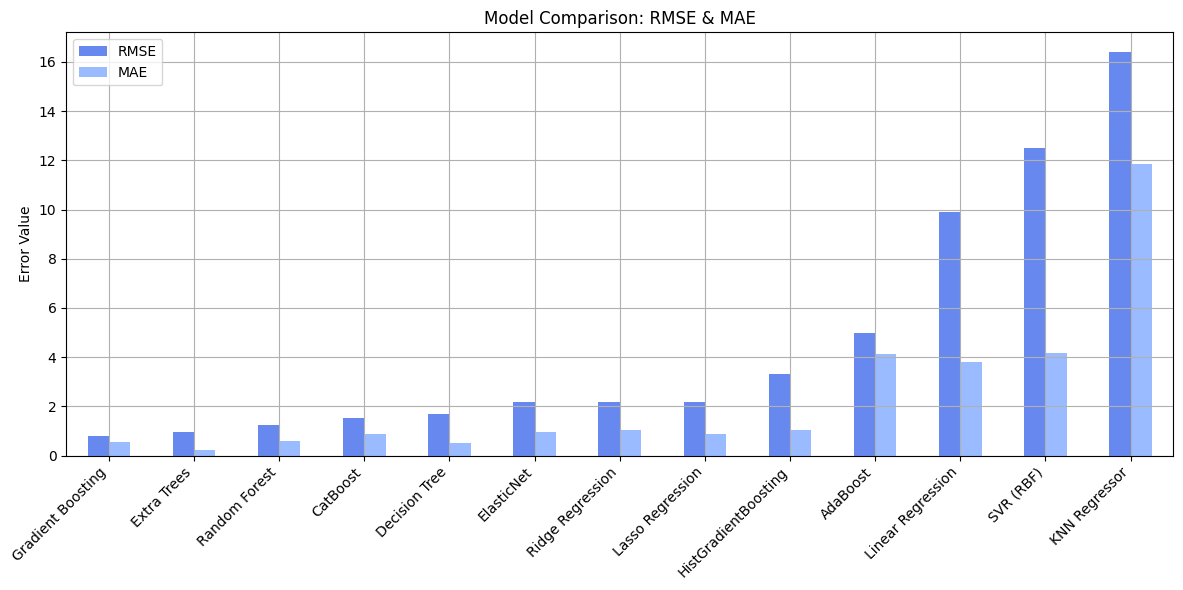


🏆 Best Model: Gradient Boosting
MAE     0.569585
RMSE    0.806041
R2      0.999580
Name: Gradient Boosting, dtype: float64
💾 Saved best model as Gradient_Boosting_SalaryModel.pkl


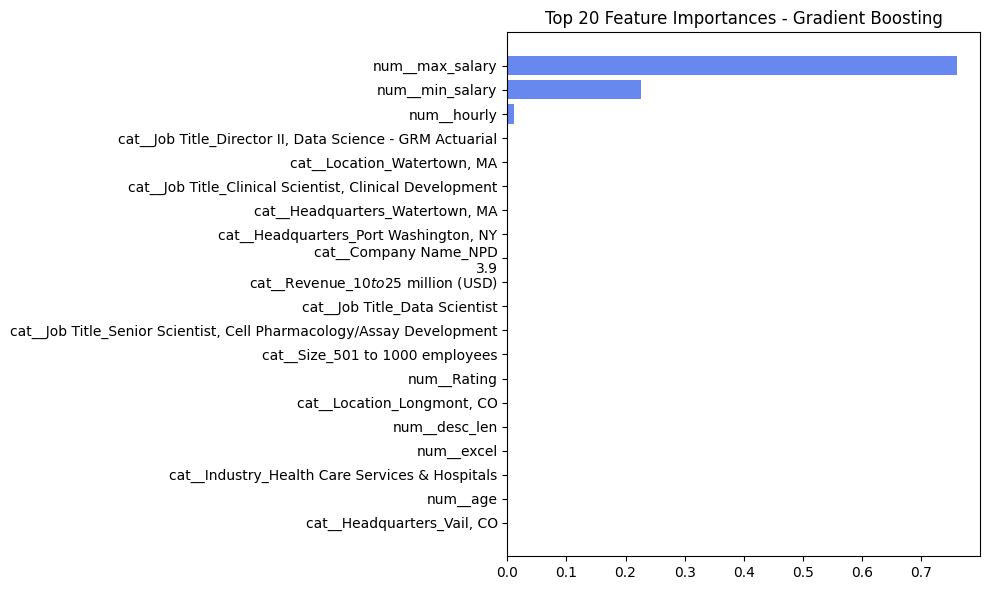


📈 Cross-Validated R² (mean ± std): 0.9967 ± 0.0022


In [88]:
# ==============================================
# 🔹 ADVANCED MODEL TRAINING & EVALUATION - SALARY PREDICTION (FINAL VERSION)
# ==============================================

# --- IMPORTS ---
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import (
    RandomForestRegressor,
    GradientBoostingRegressor,
    AdaBoostRegressor,
    ExtraTreesRegressor,
    HistGradientBoostingRegressor
)
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib

# ==============================================
# 1️⃣ DEFINE FEATURES & TARGET
# ==============================================
# Assuming df is your cleaned dataset with avg_salary
X = df.drop(columns=['avg_salary'], errors='ignore')
y = df['avg_salary']

# ==============================================
# 2️⃣ DEFINE FEATURE TYPES
# ==============================================
num_features = [
    'Rating', 'Founded', 'min_salary', 'max_salary', 'age',
    'desc_len', 'num_comp', 'hourly', 'employer_provided',
    'same_state', 'python_yn', 'R_yn', 'spark', 'aws', 'excel'
]

cat_features = [
    'Job Title', 'Company Name', 'Location', 'Headquarters', 'Size',
    'Type of ownership', 'Industry', 'Sector', 'Revenue',
    'job_state', 'job_simp', 'seniority'
]

# ==============================================
# 3️⃣ SPLIT DATA (Train/Test)
# ==============================================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# ==============================================
# 4️⃣ PREPROCESSING PIPELINE
# ==============================================
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_features)
    ],
    remainder='drop'
)

# Fit and transform on training data
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Get feature names
feature_names = preprocessor.get_feature_names_out()

# Convert to DataFrame
X_train_df = pd.DataFrame(X_train_processed, columns=feature_names)
X_test_df = pd.DataFrame(X_test_processed, columns=feature_names)

# Ensure all numeric dtypes
X_train_df = X_train_df.apply(pd.to_numeric, errors='coerce')
X_test_df = X_test_df.apply(pd.to_numeric, errors='coerce')

# ==============================================
# 5️⃣ DEFINE MODELS
# ==============================================
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0, random_state=42),
    "Lasso Regression": Lasso(alpha=0.001, random_state=42),
    "ElasticNet": ElasticNet(alpha=0.001, l1_ratio=0.5, random_state=42),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=300, n_jobs=-1, random_state=42),
    "Extra Trees": ExtraTreesRegressor(n_estimators=300, n_jobs=-1, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=300, random_state=42),
    "HistGradientBoosting": HistGradientBoostingRegressor(max_iter=300, random_state=42),
    "AdaBoost": AdaBoostRegressor(n_estimators=200, random_state=42),
    "KNN Regressor": KNeighborsRegressor(n_neighbors=5),
    "SVR (RBF)": SVR(kernel='rbf', C=10, epsilon=0.2),
    "XGBoost": XGBRegressor(
        n_jobs=-1, random_state=42, verbosity=0,
        learning_rate=0.1, n_estimators=400, max_depth=6
    ),
    "LightGBM": LGBMRegressor(
        n_jobs=-1, random_state=42, verbose=-1,
        learning_rate=0.1, n_estimators=400
    ),
    "CatBoost": CatBoostRegressor(
        n_estimators=400, learning_rate=0.1, depth=6, random_state=42,
        verbose=False
    ),
}

# ==============================================
# 6️⃣ TRAIN & EVALUATE MODELS
# ==============================================
results = {}
print("🔍 Model Evaluation Results:")
print("-" * 80)

for name, model in models.items():
    try:
        # ✅ Uniform handling (no .values -> fixes LightGBM warning)
        model.fit(X_train_df, y_train)
        y_pred = model.predict(X_test_df)

        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)

        results[name] = {"MAE": mae, "RMSE": rmse, "R2": r2}
        print(f"{name:22} | MAE: {mae:8.3f} | RMSE: {rmse:8.3f} | R²: {r2:7.4f}")

    except Exception as e:
        print(f"❌ {name:22} failed: {e}")

# ==============================================
# 7️⃣ COMPARE RESULTS
# ==============================================
performance_df = pd.DataFrame(results).T.sort_values(by='RMSE')
print("\n📊 Sorted Model Performance (Lowest RMSE on Top):")
print(performance_df.round(4))

# ==============================================
# 8️⃣ VISUAL COMPARISON
# ==============================================
plt.figure(figsize=(12,6))
performance_df[['RMSE', 'MAE']].plot(kind='bar', figsize=(12,6), grid=True)
plt.title("Model Comparison: RMSE & MAE")
plt.ylabel("Error Value")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# ==============================================
# 9️⃣ BEST MODEL SUMMARY & SAVE
# ==============================================
best_model_name = performance_df.index[0]
print(f"\n🏆 Best Model: {best_model_name}")
best_model_metrics = performance_df.loc[best_model_name]
print(best_model_metrics)

best_model = models[best_model_name]
joblib.dump(best_model, f"{best_model_name.replace(' ', '_')}_SalaryModel.pkl")
print(f"💾 Saved best model as {best_model_name.replace(' ', '_')}_SalaryModel.pkl")

# ==============================================
# 🔟 FEATURE IMPORTANCE (Tree-based models only)
# ==============================================
if hasattr(best_model, "feature_importances_"):
    importances = best_model.feature_importances_
    indices = np.argsort(importances)[::-1][:20]
    plt.figure(figsize=(10,6))
    plt.barh(range(len(indices)), importances[indices][::-1])
    plt.yticks(range(len(indices)), np.array(feature_names)[indices][::-1])
    plt.title(f"Top 20 Feature Importances - {best_model_name}")
    plt.tight_layout()
    plt.show()
else:
    print(f"ℹ️ {best_model_name} does not support feature importances.")

# ==============================================
# 1️⃣1️⃣ CROSS-VALIDATION CHECK (Overfitting Test)
# ==============================================
cv_r2 = cross_val_score(best_model, X_train_df, y_train, cv=5, scoring='r2')
print(f"\n📈 Cross-Validated R² (mean ± std): {cv_r2.mean():.4f} ± {cv_r2.std():.4f}")


In [89]:
# # ==============================================
# # 🔹 HYPERPARAMETER TUNING - GRADIENT BOOSTING REGRESSOR
# # ==============================================

# from sklearn.ensemble import GradientBoostingRegressor
# from sklearn.model_selection import GridSearchCV, cross_val_score
# from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# import numpy as np
# import pandas as pd
# import joblib

# # --- Base model ---
# base_model = GradientBoostingRegressor(n_estimators=300, random_state=42)
# base_model.fit(X_train_df, y_train)
# base_preds = base_model.predict(X_test_df)

# base_mae = mean_absolute_error(y_test, base_preds)
# base_rmse = np.sqrt(mean_squared_error(y_test, base_preds))
# base_r2 = r2_score(y_test, base_preds)

# print(f"\n⚙️ Base Gradient Boosting Performance:")
# print(f"MAE: {base_mae:.3f} | RMSE: {base_rmse:.3f} | R²: {base_r2:.4f}")

# # --- Hyperparameter grid ---
# param_grid = {
#     'n_estimators': [200, 300, 400],
#     'learning_rate': [0.05, 0.1, 0.2],
#     'max_depth': [3, 4, 5],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
#     'subsample': [0.8, 1.0],
#     'max_features': ['sqrt', 'log2']
# }

# # --- Grid Search ---
# print("\n🔍 Starting Grid Search for Gradient Boosting...")
# grid = GridSearchCV(
#     estimator=GradientBoostingRegressor(random_state=42),
#     param_grid=param_grid,
#     scoring='neg_mean_absolute_error',
#     cv=3,
#     n_jobs=-1,
#     verbose=1
# )
# grid.fit(X_train_df, y_train)

# best_gb = grid.best_estimator_
# print(f"\n✅ Best Parameters: {grid.best_params_}")

# # --- Evaluate tuned model ---
# y_pred = best_gb.predict(X_test_df)
# mae = mean_absolute_error(y_test, y_pred)
# rmse = np.sqrt(mean_squared_error(y_test, y_pred))
# r2 = r2_score(y_test, y_pred)

# print(f"\n📈 Tuned Gradient Boosting Performance:")
# print(f"MAE: {mae:.3f} | RMSE: {rmse:.3f} | R²: {r2:.4f}")

# # --- Compare with base model ---
# print("\n📊 Comparison:")
# comparison = pd.DataFrame({
#     'Model': ['Base GB', 'Tuned GB'],
#     'MAE': [base_mae, mae],
#     'RMSE': [base_rmse, rmse],
#     'R²': [base_r2, r2]
# })
# print(comparison.round(4))

# # --- Cross-validation check ---
# cv_r2 = cross_val_score(best_gb, X_train_df, y_train, cv=5, scoring='r2')
# print(f"\n🧠 Cross-Validated R² (mean ± std): {cv_r2.mean():.4f} ± {cv_r2.std():.4f}")

# # --- Save best model ---
# joblib.dump(best_gb, "GradientBoosting_Tuned_SalaryModel.pkl")
# print("\n💾 Saved best tuned model as GradientBoosting_Tuned_SalaryModel.pkl")


### Uppar wala bohot time lagayega kuki it considers all 972 parameters combinitng with 3 folds that's like **2,916** fits so expect to take it more than 15mins

(comment it and uncomment the code below to make it faster)

Steps:
* Ctrl + A
* Ctrl + /

In [90]:
# ==============================================
# 🔹 SMART GRID SEARCH - GRADIENT BOOSTING REGRESSOR (FAST & EFFICIENT)
# ==============================================

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd
import joblib

# --- Base Gradient Boosting (for reference) ---
base_model = GradientBoostingRegressor(n_estimators=300, random_state=42)
base_model.fit(X_train_df, y_train)
base_preds = base_model.predict(X_test_df)

base_mae = mean_absolute_error(y_test, base_preds)
base_rmse = np.sqrt(mean_squared_error(y_test, base_preds))
base_r2 = r2_score(y_test, base_preds)

print(f"\n⚙️ Base Gradient Boosting Performance:")
print(f"MAE: {base_mae:.3f} | RMSE: {base_rmse:.3f} | R²: {base_r2:.4f}")

# --- Step 1: Sample a subset for faster tuning ---
# Use 25–30% of training data for hyperparameter tuning
X_tune, _, y_tune, _ = train_test_split(
    X_train_df, y_train, test_size=0.7, random_state=42
)
print(f"\n📊 Using subset for tuning: {X_tune.shape[0]} samples out of {X_train_df.shape[0]}")

# --- Step 2: Focused Grid for faster, meaningful search ---
param_grid = {
    'n_estimators': [200, 300, 400],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 4],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'subsample': [0.8, 1.0],
    'max_features': ['sqrt']
}

# --- Step 3: Grid Search (Fast) ---
print("\n🔍 Starting Optimized Grid Search (small subset, focused grid)...")
grid = GridSearchCV(
    estimator=GradientBoostingRegressor(random_state=42),
    param_grid=param_grid,
    scoring='neg_mean_absolute_error',
    cv=3,
    n_jobs=-1,
    verbose=2
)
grid.fit(X_tune, y_tune)

best_gb = grid.best_estimator_
print(f"\n✅ Best Parameters: {grid.best_params_}")

# --- Step 4: Evaluate Tuned Model on Full Test Set ---
y_pred = best_gb.predict(X_test_df)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"\n📈 Tuned Gradient Boosting Performance (Full Test Set):")
print(f"MAE: {mae:.3f} | RMSE: {rmse:.3f} | R²: {r2:.4f}")

# --- Step 5: Compare with Base Model ---
comparison = pd.DataFrame({
    'Model': ['Base GB', 'Tuned GB (Subset)'],
    'MAE': [base_mae, mae],
    'RMSE': [base_rmse, rmse],
    'R²': [base_r2, r2]
})
print("\n📊 Comparison Summary:")
print(comparison.round(4))

# --- Step 6: Cross-validation for stability check ---
cv_r2 = cross_val_score(best_gb, X_train_df, y_train, cv=3, scoring='r2', n_jobs=-1)
print(f"\n🧠 Cross-Validated R² (mean ± std): {cv_r2.mean():.4f} ± {cv_r2.std():.4f}")

# --- Step 7: Save the Tuned Model ---
joblib.dump(best_gb, "GradientBoosting_Tuned_SalaryModel_Fast.pkl")
print("\n💾 Saved tuned model as GradientBoosting_Tuned_SalaryModel_Fast.pkl")



⚙️ Base Gradient Boosting Performance:
MAE: 0.570 | RMSE: 0.806 | R²: 0.9996

📊 Using subset for tuning: 253 samples out of 846

🔍 Starting Optimized Grid Search (small subset, focused grid)...
Fitting 3 folds for each of 96 candidates, totalling 288 fits

✅ Best Parameters: {'learning_rate': 0.1, 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 400, 'subsample': 1.0}

📈 Tuned Gradient Boosting Performance (Full Test Set):
MAE: 8.292 | RMSE: 16.277 | R²: 0.8289

📊 Comparison Summary:
               Model     MAE     RMSE      R²
0            Base GB  0.5696   0.8060  0.9996
1  Tuned GB (Subset)  8.2922  16.2768  0.8289

🧠 Cross-Validated R² (mean ± std): 0.9605 ± 0.0077

💾 Saved tuned model as GradientBoosting_Tuned_SalaryModel_Fast.pkl


In [95]:
import joblib
X_train_processed = preprocessor.fit_transform(X_train)

# Save the *original fitted* preprocessor that created X_train_processed
joblib.dump(preprocessor, "salary_preprocessor.pkl")
joblib.dump(best_gb, "GradientBoosting_Tuned_SalaryModel_Fast.pkl")
print("✅ Original preprocessor + model saved.")

model = joblib.load("GradientBoosting_Tuned_SalaryModel_Fast.pkl")
preprocessor = joblib.load("salary_preprocessor.pkl")
X_processed = preprocessor.transform(X)  # ⚠️ use transform, NOT fit_transform


✅ Original preprocessor + model saved.


In [96]:
# ==============================================
# 🔹 FINAL MODEL TESTING & RESULT COMPARISON (FIXED)
# ==============================================

import pandas as pd
import numpy as np
import joblib
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# --- Step 1: Load model + preprocessor ---
model = joblib.load("GradientBoosting_Tuned_SalaryModel_Fast.pkl")
preprocessor = joblib.load("salary_preprocessor.pkl")
print("✅ Model and preprocessor loaded successfully.")

# --- Step 2: Prepare dataset ---
X = df.drop(columns=['avg_salary'])
y_true = df['avg_salary']

# --- Step 3: Transform using the SAME preprocessor ---
X_processed = preprocessor.transform(X)
print("✅ Data transformed successfully (same feature alignment).")

# --- Step 4: Predict ---
y_pred = model.predict(X_processed)
y_pred = np.round(y_pred, 3)

# --- Step 5: Evaluate ---
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)

print("\n📊 Final Evaluation on Full Dataset:")
print(f"MAE:  {mae:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"R²:   {r2:.4f}")

# --- Step 6: Save comparison file ---
result_df = pd.DataFrame({
    "Predicted_avg_salary": y_pred,
    "Actual_avg_salary": y_true
})
result_df.to_csv("result.csv", index=False)
print("\n💾 result.csv saved successfully. You can now compare predictions with actual values.")


✅ Model and preprocessor loaded successfully.
✅ Data transformed successfully (same feature alignment).

📊 Final Evaluation on Full Dataset:
MAE:  6.815
RMSE: 14.206
R²:   0.8620

💾 result.csv saved successfully. You can now compare predictions with actual values.


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names



In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# --- Step 1: Load predictions ---
result = pd.read_csv("result.csv")

# --- Step 2: Attach actual values from df ---
# Ensure same row alignment
ground_truth = df['avg_salary'].reset_index(drop=True)

# --- Step 3: Combine both ---
comparison_df = pd.DataFrame({
    "Actual": ground_truth,
    "Predicted": result["Predicted_avg_salary"]
})

# --- Step 4: Drop rows where Actual is missing ---
valid_data = comparison_df.dropna(subset=["Actual"]).reset_index(drop=True)

# --- Step 5: Calculate Kaggle-style metrics ---
mae = mean_absolute_error(valid_data["Actual"], valid_data["Predicted"])
rmse = np.sqrt(mean_squared_error(valid_data["Actual"], valid_data["Predicted"]))
r2 = r2_score(valid_data["Actual"], valid_data["Predicted"])

# --- Step 6: Print leaderboard-style results ---
print("🏆 Kaggle-Style Evaluation Results:")
print("---------------------------------------")
print(f"✅ Valid Samples: {len(valid_data)} / {len(comparison_df)}")
print(f"MAE (Mean Absolute Error):      {mae:.4f}")
print(f"RMSE (Root Mean Squared Error): {rmse:.4f}")
print(f"R² Score:                       {r2:.4f}")

# --- Step 7: Optional leaderboard output ---
leaderboard = pd.DataFrame({
    "Metric": ["MAE", "RMSE", "R2"],
    "Score": [mae, rmse, r2]
}).set_index("Metric")

print("\n📊 Leaderboard Summary:")
print(leaderboard.round(4))

🏆 Kaggle-Style Evaluation Results:
---------------------------------------
✅ Valid Samples: 1209 / 1209
MAE (Mean Absolute Error):      6.8153
RMSE (Root Mean Squared Error): 14.2062
R² Score:                       0.8620

📊 Leaderboard Summary:
          Score
Metric         
MAE      6.8153
RMSE    14.2062
R2       0.8620


# 86% Accuracy